In [1]:
#what happens if we build a circuit variational template but with basis gates that are parameters
#I think the guess, and eval functions wil be messed up but we can start with that
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

import sys
sys.path.append("../../")
import numpy as np

# %matplotlib widget

In [2]:
from ast import Param
from src.utils.custom_gates import RiSwapGate
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library.standard_gates import iSwapGate, CPhaseGate, RZGate, RXXGate
a = Parameter('a')
#RXXGate(a)
RiSwapGate(a)
#RZGate(a)
#iSwapGate().power(1/a)
#CPhaseGate(a)

Instruction(name='riswap', num_qubits=2, num_clbits=0, params=[Parameter(a)])

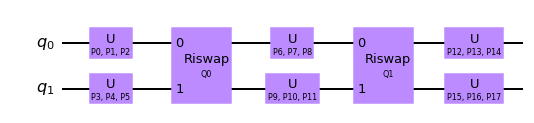

In [3]:
from src.basisv2 import CircuitTemplateV2
basis = CircuitTemplateV2(n_qubits=2, base_gates=[RiSwapGate])
basis.build(2)
basis.spanning_range = range(2,4)
basis.circuit.draw(output='mpl')

In [4]:
from src.cost_function import BasicCostInverse, BasicCost
objective1 = BasicCost()
objective2 = BasicCostInverse()
from src.optimizer import TemplateOptimizer
optimizer = TemplateOptimizer(basis=basis, objective=objective2, use_callback=True, override_fail=True)

In [6]:
from src.sampler import HaarSample
sampler = HaarSample(seed=0,n_samples=1)
s = [s for s in sampler][0]
ret = optimizer.approximate_target_U(s)

INFO:root:Begin search: (0.49741881, 0.30805173, 0.042267)
INFO:root:Starting opt on template size 2
INFO:root:Break on cycle 2
INFO:root:Loss=-168.240490987785
INFO:root:Success: (0.49741881, 0.30805173, 0.042267)


In [5]:
basis.build(ret.cycles)
circuit =basis.assign_Xk(ret.Xk)
print("Decomposition Fidelity", objective2.unitary_fidelity(basis.eval(ret.Xk), s))
print("Circuit Fidelity", basis.circuit_fidelity(ret.Xk))
print("Total Fidelity", 1-ret.loss_result)
circuit.draw(output='mpl')

NameError: name 'ret' is not defined

In [8]:
#TODO if use monodromy for 2Q case, can use cost function only relating to 2Q gate duration
#1. define a distance between coverage and point
#2. build coverage from the alpha parameters

In [6]:
from src.utils.polytope_wrap import gate_set_to_coverage
coverage = gate_set_to_coverage(RiSwapGate(1/2))

INFO:root:==== Working to build a set of covering polytopes ====


Considering $\sqrt[2]{iSwap}$;	Cost 0.5 and Euclidean volume   0.00%
Considering $\sqrt[2]{iSwap}$·$\sqrt[2]{iSwap}$;	Cost 1.0 and Euclidean volume  50.00%
Considering $\sqrt[2]{iSwap}$·$\sqrt[2]{iSwap}$·$\sqrt[2]{iSwap}$;	Cost 1.5 and Euclidean volume 100.00%


INFO:root:==== Done. Here's what we found: ====
INFO:root:Percent volume of A_C2	 | Cost	 | Sequence name
  0.00% =    0/1    	 | 0.00	 | 
  0.00% =    0/1    	 | 0.50	 | $\sqrt[2]{iSwap}$
 50.00% =    1/2    	 | 1.00	 | $\sqrt[2]{iSwap}$.$\sqrt[2]{iSwap}$
100.00% =    1/1    	 | 1.50	 | $\sqrt[2]{iSwap}$.$\sqrt[2]{iSwap}$.$\sqrt[2]{iSwap}$



In [4]:
reduced_vertices = coverage

In [7]:
from monodromy.coordinates import monodromy_to_positive_canonical_polytope
from src.utils.polytope_wrap import gate_set_to_coverage

In [8]:
from qiskit.circuit.library import RZXGate
import numpy as np

#gates = [RZXGate(np.pi/3), RZXGate(np.pi/3), RZXGate(np.pi/3), RZXGate(np.pi/3)]
# gates = [RiSwapGate(1/4), RiSwapGate(1/4).inverse()]# RiSwapGate(1/3), RiSwapGate(1/4)]

from fractions import Fraction
from monodromy.coordinates import monodromy_to_positive_canonical_polytope, positive_canonical_alcove_c2, unitary_to_monodromy_coordinate
from monodromy.coverage import deduce_qlr_consequences
from monodromy.static.examples import exactly, identity_polytope, everything_polytope

base_iswap_fidelity = .95
def get_circuit_polytope(*basis_gate:RiSwapGate):

    circuit_polytope = identity_polytope

    for gate in basis_gate:
        b_polytope = exactly(
            *(Fraction(x).limit_denominator(10_000)
            for x in unitary_to_monodromy_coordinate(gate.to_matrix())[:-1])
        )
        circuit_polytope = deduce_qlr_consequences(
            target="c",
            a_polytope=circuit_polytope,
            b_polytope=b_polytope,
            c_polytope=everything_polytope
        )
    
    # return circuit_polytope
    from monodromy.coverage import CircuitPolytope
    return CircuitPolytope(
            operations="cnot",#[RiSwapGate.latex_string(basis_gate[0].params)],
            #cost=1 - (1- base_iswap_fidelity)*basis_gate.params[0],
            cost=1,#basis_gate[0].params[0],
            convex_subpolytopes=circuit_polytope.convex_subpolytopes,
    )

In [16]:
# polytope_vertices = monodromy_to_positive_canonical_polytope(circuit_polytope).vertices
from qiskit.circuit.library.standard_gates import CZGate, CXGate
#circuit_polytope = get_circuit_polytope(RiSwapGate(1/2), RiSwapGate(1/2))
#circuit_polytope = get_circuit_polytope(CZGate(), CZGate())
from qiskit.circuit.library.standard_gates import SwapGate
#circuit_polytope = get_circuit_polytope(CZGate().power(1), CZGate().power(1))
# from src.utils.custom_gates import CustomCostGate
# circuit_polytope = get_circuit_polytope(CustomCostGate(CXGate(), "CX"), CustomCostGate(CXGate(), "CX"))
circuit_polytope = get_circuit_polytope(CXGate(), CXGate())
reduced_vertices = monodromy_to_positive_canonical_polytope(circuit_polytope.reduce()).vertices

In [32]:
from qiskit.circuit.library import CXGate
gate = CXGate()
from monodromy.coordinates import monodromy_to_positive_canonical_coordinate, unitary_to_monodromy_coordinate
unitary_to_monodromy_coordinate(CXGate().to_matrix())

[0.25000000000000033, 0.25, -0.0877627345845371, -0.4122372654154639]

In [31]:
gate = CXGate()
from monodromy.coordinates import monodromy_to_positive_canonical_coordinate
monodromy_to_positive_canonical_coordinate(*unitary_to_monodromy_coordinate(gate.to_matrix())[:-1])

(0.7853981633974488, 0.25484170058385835, 0.25484170058385786)

In [17]:
circuit_polytope

CircuitPolytope(convex_subpolytopes=[ConvexPolytope(inequalities=[[0, 0, 1, -1], [1, -2, -2, -2], [525, 0, -1618, -1618], [-525, 1618, 1618, 0], [0, 0, 1, 1], [0, 1, -1, 0]], equalities=[], name='True ∩ QLR relations ∩ A_SU(4)^monodromy ∩ A_SU(4)^monodromy ∩ A_SU(4)^monodromy ∩ True ∩ QLR relations ∩ A_SU(4)^monodromy ∩ A_SU(4)^monodromy ∩ A_SU(4)^monodromy ∩ origin ∩ anonymous_convex_polytope_21 ∩ True ∩ A_PU(4)^monodromy ∩ anonymous_convex_polytope_23 ∩ True ∩ A_PU(4)^monodromy'), ConvexPolytope(inequalities=[[0, 0, 1, 1], [0, 1, -1, 0], [0, 0, 0, -1], [1093, -1618, -1618, 0], [1, -2, -1, -1], [525, 0, -1618, -1618]], equalities=[], name='anonymous_convex_polytope_24 ∩ A_SU(4)^monodromy ∩ A_SU(4)^monodromy ∩ A_SU(4)^monodromy ∩ True ∩ QLR relations ∩ A_SU(4)^monodromy ∩ A_SU(4)^monodromy ∩ A_SU(4)^monodromy ∩ origin ∩ anonymous_convex_polytope_21 ∩ True ∩ A_PU(4)^monodromy ∩ anonymous_convex_polytope_23 ∩ True ∩ A_PU(4)^monodromy')], cost=1, operations='cnot')

In [58]:
reduced_vertices

[[[Fraction(6156949, 18975138),
   Fraction(6156949, 18975138),
   Fraction(6156949, 18975138)],
  [Fraction(6156949, 18975138), Fraction(0, 1), Fraction(0, 1)],
  [Fraction(6156949, 18975138), Fraction(6156949, 18975138), Fraction(0, 1)],
  [Fraction(1, 2), Fraction(1, 2), Fraction(0, 1)],
  [Fraction(1, 1), Fraction(0, 1), Fraction(0, 1)],
  [Fraction(12818189, 37950276),
   Fraction(12818189, 37950276),
   Fraction(6156949, 18975138)],
  [Fraction(3330620, 9487569),
   Fraction(6156949, 18975138),
   Fraction(6156949, 18975138)]],
 [[Fraction(6156949, 9487569),
   Fraction(6156949, 18975138),
   Fraction(6156949, 18975138)],
  [Fraction(0, 1), Fraction(0, 1), Fraction(0, 1)],
  [Fraction(12818189, 18975138),
   Fraction(6156949, 18975138),
   Fraction(6156949, 18975138)],
  [Fraction(12818189, 18975138), Fraction(0, 1), Fraction(0, 1)],
  [Fraction(12818189, 18975138), Fraction(6156949, 18975138), Fraction(0, 1)],
  [Fraction(25132087, 37950276),
   Fraction(12818189, 37950276),
   

In [10]:
%matplotlib widget

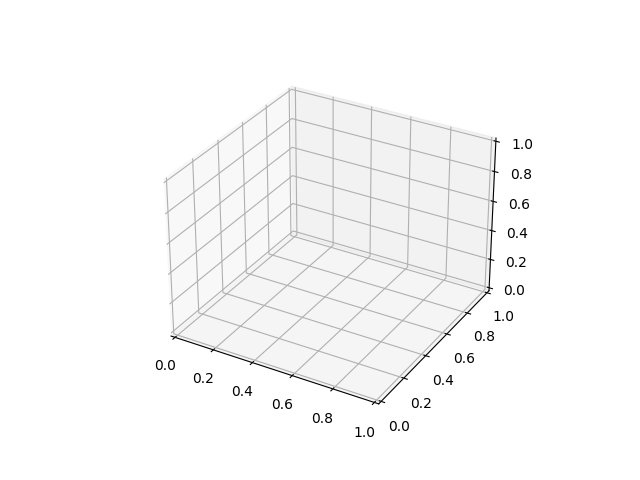

In [59]:
import matplotlib.pyplot as plt
plt.close()
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

from weylchamber import WeylChamber
w = WeylChamber();

In [60]:
total_coord_list = []
subpoly_list = []
for subpoly in reduced_vertices:
    subpoly_coords = [[float(x) for x in coord] for coord in subpoly]
    total_coord_list += subpoly_coords
    subpoly_list.append(subpoly_coords)
    w.scatter(*zip(*subpoly_coords))

# from scipy.spatial import ConvexHull
# #pts = np.array(total_coord_list)
# for sc in subpoly_list:
#     pts = np.array(sc)
#     hull = ConvexHull(pts)
#     for s in hull.simplices:
#         s = np.append(s, s[0])  # Here we cycle back to the first coordinate
#         ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], color='blue')

pts = np.array(total_coord_list + [total_coord_list[0]])
 #wrap around
for si in range(len(pts[:-1])):
    dv = np.transpose([pts[si], pts[si+1]])
    ax.plot(dv[0], dv[1], dv[2], color='red')

In [22]:
# from weylchamber import c1c2c3
# from qiskit.circuit.library.standard_gates import CPhaseGate
# from qiskit.quantum_info import Operator
# w.add_point(*c1c2c3(Operator(CPhaseGate(np.pi/2)).data))

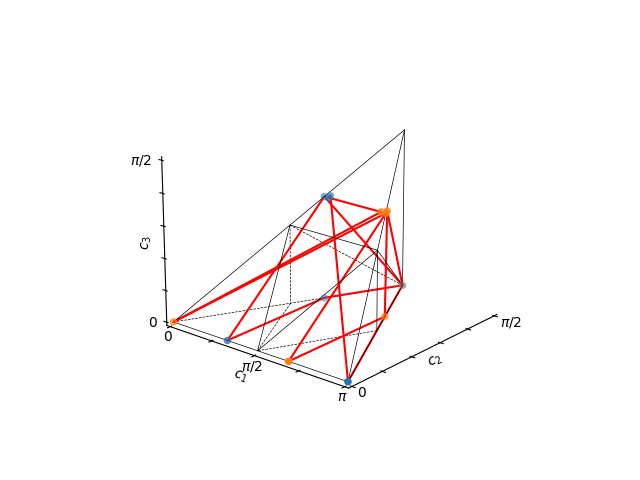

In [61]:
w.labels = {}
w.render(ax)
#plt.savefig("weyl.svg", format='svg', facecolor='None')
fig.show()

By inspection, it seems in order to be on the C(U) line, we need both iSwaps to be the same. Strangely, when I move basis into 3 applications of the gate, the function to build circuitpolytope takes 30+mins/never converges. I think this is strange because I can build coverage sets with \sqrt{3} gates rapidly. If I can build a coverage set, doesn't that also give me all the polytopes? Maybe not - coverage can skip steps-only consider points not a subset of already covered points (idk if this is true just an idea).

In [9]:
np.matrix(gates.RiSwapGate(1/2))

matrix([[1.        +0.j        , 0.        +0.j        ,
         0.        +0.j        , 0.        +0.j        ],
        [0.        +0.j        , 0.70710678+0.j        ,
         0.        +0.70710678j, 0.        +0.j        ],
        [0.        +0.j        , 0.        +0.70710678j,
         0.70710678+0.j        , 0.        +0.j        ],
        [0.        +0.j        , 0.        +0.j        ,
         0.        +0.j        , 1.        +0.j        ]])

In [8]:
from src.utils.polytope_wrap import gate_set_to_coverage
coverage = gate_set_to_coverage([gates.RiSwapGate(1/2)])

/home/evm9/decomposition_EM/decomp_venv/lib/python3.8/site-packages/numpy/matrixlib/defmatrix.py:145: FutureWarning: The input object of type 'RiSwapGate' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'RiSwapGate', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = N.array(data, dtype=dtype, copy=copy)


TypeError: must be real number, not RiSwapGate

NameError: name 'reduced_vertices' is not defined

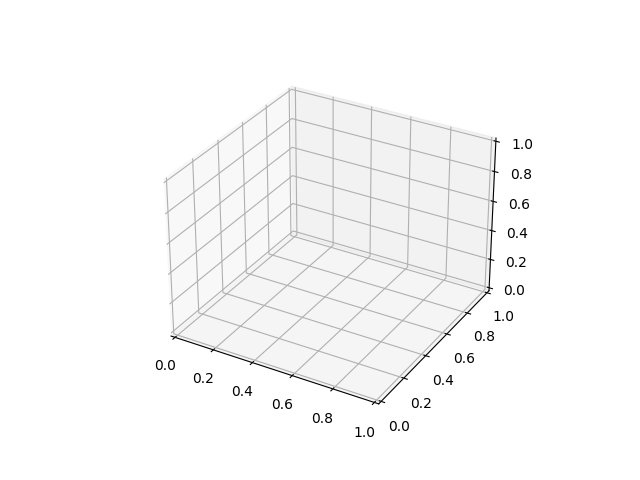

In [7]:
%matplotlib widget

import matplotlib.pyplot as plt
plt.close()
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

from weylchamber import WeylChamber
w = WeylChamber();

total_coord_list = []
for subpoly in reduced_vertices:
    subpoly_coords = [[float(x) for x in coord] for coord in subpoly]
    total_coord_list += subpoly_coords
    w.scatter(*zip(*subpoly_coords))

from scipy.spatial import ConvexHull
pts = np.array(total_coord_list)
hull = ConvexHull(pts)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "r-")

w.render(ax)

In [8]:
#TODO: force setting to make 2Q params homogenous
#TODO: constraint each gate is less than .5, vs total gates less than 1.5 as upperbound for known Haar decomp (or less than 1 depending on the target)

In [10]:
#can we use this circuit template to construct an entangled state
#1. we might define a new cost function that maximizes the entanglement (entropy-metric)
qc = QuantumCircuit(3)
qc.ry(2*np.arccos(1/np.sqrt(3)),0)
qc.ch(0,1)
qc.cx(1,2)
qc.cx(0,1)
qc.x(0)
from qiskit.quantum_info import Operator
w_state = Operator(qc).data
qc.draw()

┌────────────┐               ┌───┐
q_0: ┤ Ry(1.9106) ├──■─────────■──┤ X ├
     └────────────┘┌─┴─┐     ┌─┴─┐└───┘
q_1: ──────────────┤ H ├──■──┤ X ├─────
                   └───┘┌─┴─┐└───┘     
q_2: ───────────────────┤ X ├──────────
                        └───┘

In [19]:
qc = QuantumCircuit(3)
qc.cp(np.pi/2,0,1)
qc.cp(np.pi/4,0,2)
qc.cp(np.pi/2,1,2)
from qiskit.quantum_info import Operator
qft_block = Operator(qc).data
qc.draw()

q_0: ─■────────■────────────────
      │P(π/2)  │                
q_1: ─■────────┼────────■───────
               │P(π/4)  │P(π/2) 
q_2: ──────────■────────■───────

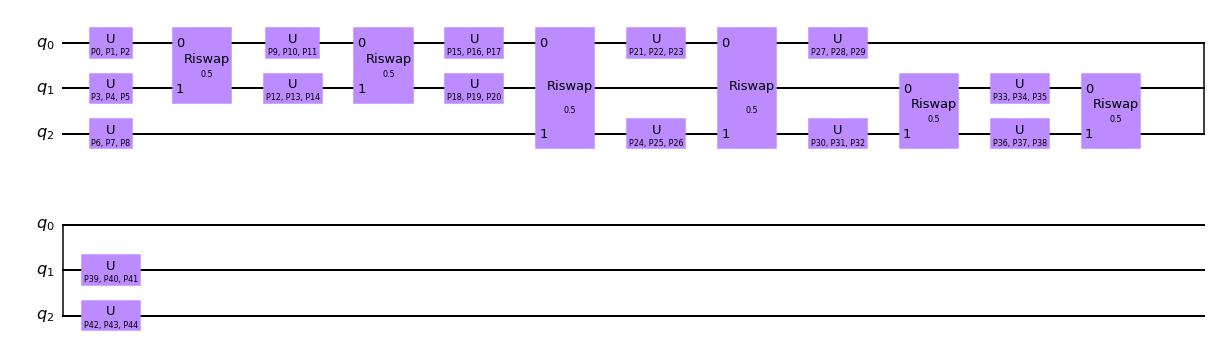

In [26]:
from src.basis import CircuitTemplate
basis1 = CircuitTemplate(n_qubits=3, base_gates=[RiSwapGate(1/2)], edge_params=[[(0,1),  (0,1), (0,2), (0,2), (1,2), (1,2)]])
basis1.build(6)
basis1.spanning_range = range(6,7)
basis1.circuit.draw(output='mpl')

In [27]:
optimizer = TemplateOptimizer(basis=basis1, objective=objective1, use_callback=0, override_fail=True)
# ret1 = optimizer.approximate_target_U(w_state)
ret1 = optimizer.approximate_target_U(qft_block)

INFO:root:Begin search: (-1, -1, -1, -1)
INFO:root:Starting opt on template size 6
INFO:root:Loss=0.2318222445984448


Decomposition Fidelity 0.7681777554015552
Total Fidelity 0.7681777554015552


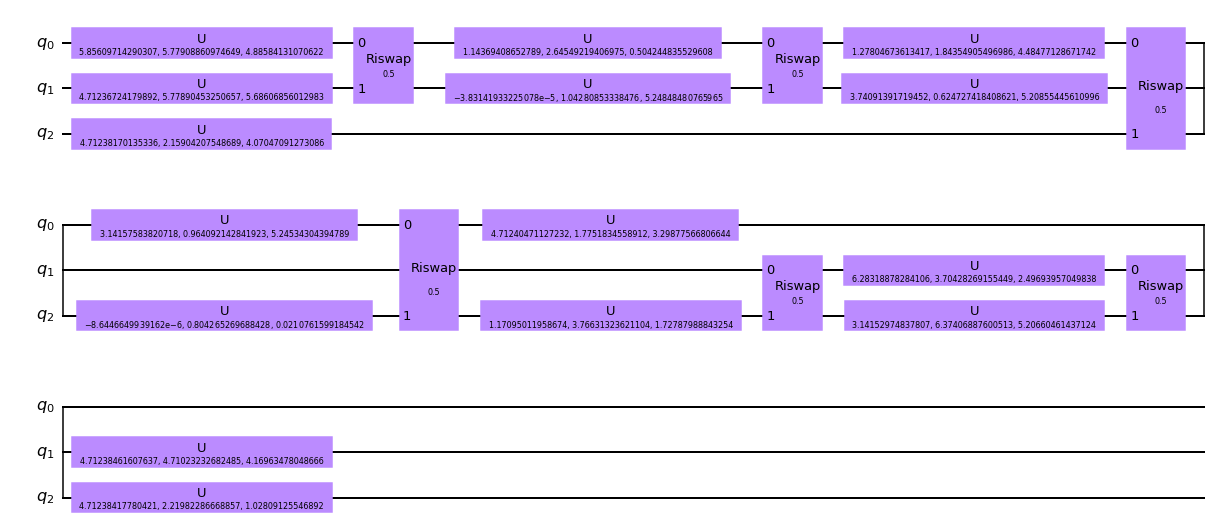

In [28]:
basis._reset()
basis1.build(ret1.cycles)
circuit =basis1.assign_Xk(ret1.Xk)
print("Decomposition Fidelity", 1-objective1.unitary_fidelity(basis1.eval(ret1.Xk), qft_block))
# print("Circuit Fidelity", basis.circuit_fidelity(ret.Xk))
print("Total Fidelity", 1-ret1.loss_result)
circuit.draw(output='mpl')

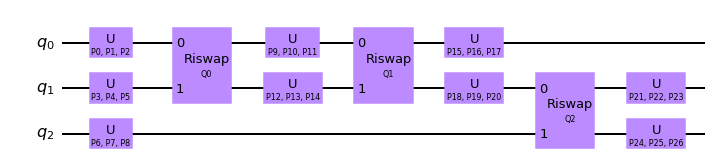

In [21]:
from src.basisv2 import CircuitTemplateV2
basis2 = CircuitTemplateV2(n_qubits=3, base_gates=[gates.RiSwapGate], edge_params=[[(0,1), (0,1), (1,2), (1,2), (0,2), (0,2)]])
basis2.build(3)
basis2.spanning_range = range(2,5)
basis2.circuit.draw(output='mpl')

In [12]:
optimizer = TemplateOptimizer(basis=basis2, objective=objective2, use_callback=True, override_fail=True)
ret2 = optimizer.approximate_target_U(w_state)

INFO:root:Begin search: (-1, -1, -1, -1)
INFO:root:Starting opt on template size 2
INFO:root:Starting opt on template size 3
INFO:root:Starting opt on template size 4
INFO:root:Loss=0.2639175680200879


Decomposition Fidelity 0.15598452940072557
Circuit Fidelity 0.9900408859811234
Total Fidelity 0.7360824319799121


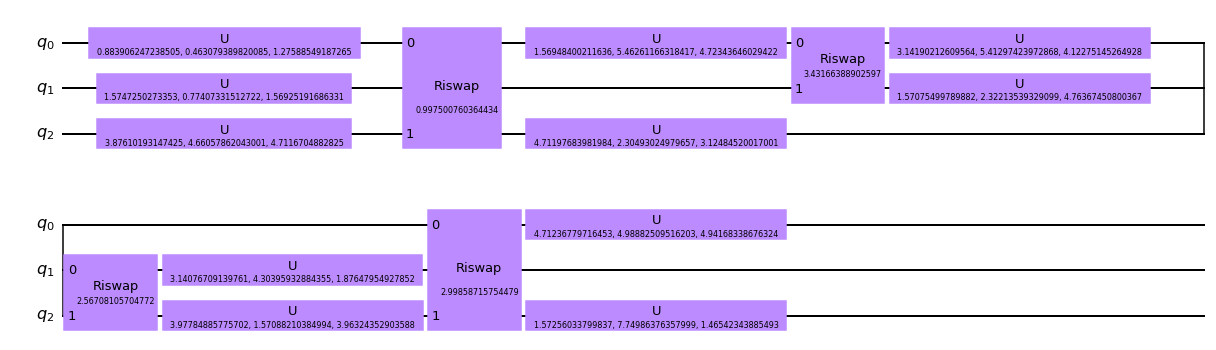

In [13]:
basis2.build(ret2.cycles)
circuit =basis2.assign_Xk(ret2.Xk)
print("Decomposition Fidelity", objective2.unitary_fidelity(basis2.eval(ret2.Xk), w_state))
print("Circuit Fidelity", basis2.circuit_fidelity(ret2.Xk))
print("Total Fidelity", 1-ret2.loss_result)
circuit.draw(output='mpl')

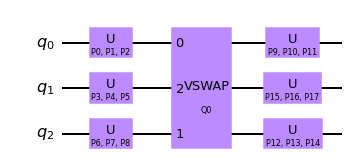

In [36]:
from src.basis import CircuitTemplate
from src.utils.custom_gates import VSwap
from src.basisv2 import CircuitTemplateV2
basis3 = CircuitTemplateV2(n_qubits=3, base_gates=[VSwap], edge_params=[[(0,1,2), (0,2,1), (1,2,0)]])
basis3.build(1)
basis3.spanning_range = range(1,2)
basis3.circuit.draw(output='mpl')

In [33]:
ub =  1
basis3.add_bound("Q0", min=0, max=ub)

In [35]:
optimizer = TemplateOptimizer(basis=basis3, objective=objective2, use_callback=True, override_fail=True)
# ret3 = optimizer.approximate_target_U(w_state)
ret3 = optimizer.approximate_target_U(qft_block)

INFO:root:Begin search: (-1, -1, -1, -1)
INFO:root:Starting opt on template size 1
INFO:root:Loss=0.12371649944551388


Decomposition Fidelity 0.6845658463416714
Circuit Fidelity 1.0
Total Fidelity 0.6845658463416714


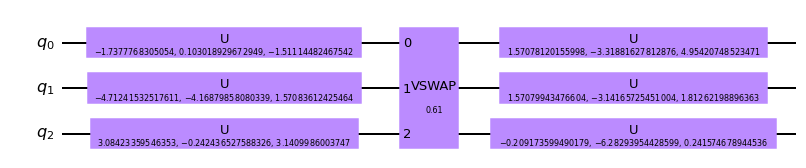

In [15]:
basis3.build(ret3.cycles)
circuit =basis3.assign_Xk(ret3.Xk)
print("Decomposition Fidelity", objective2.unitary_fidelity(basis3.eval(ret3.Xk), w_state))
print("Circuit Fidelity", basis3.circuit_fidelity(ret3.Xk))
print("Total Fidelity", 1-ret3.loss_result)
circuit.draw(output='mpl')

#### TODO
1. we need to modify the circuittemplate class so that each 2Q gate will be assigned its own parameter. If we create a second parameter vector separate from the 1Q parameters, it will be easier to handle.
2. We need to modify the cost function, using this new second parameter vector so that it knows to try and shrink the duration from the 2Q gates. We can modify the cost function using the NuOp cost function that looks like the product of decomposition fidelity and gate fidelity-I think this relies on needing a baseline iSWap fidelity.

Unfortunately, I think the best way to do this is to rewrite the entirety of the CircuitTemplate class....the key change should be to use 2 parameter vector classes, and just define a convention that the 1Q vector comes first.

For continuous parameters, we can't use monodromy. Maybe also we define a cost function, representing the circuit fidelity inside this class- so we don't have to pass around the 2Q parameter vector.

An epic goal would be to wrap the Hamiltonians in the custom cost gate class, then for an entangled unitary target (3Q) train over the hamiltonian parameters to minimize cost of circuit. If we use the 2Q gates we need to define an entanglement pattern, but if we give it an entire hamitlonian for 3Q simultanteously, I wonder if the circuit could train, fitting to the 2Q gate subclass as needed.